#SAM2 application

In [1]:
# Installazione delle librerie richieste
#!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/segment-anything.git
#!pip install opencv-python matplotlib

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ytfx7ykc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ytfx7ykc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=02827e93a2e577b8c284843859b0544e269b951f2c19ff0ead2afb64c97c87a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-xx6zl12a/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Scarica il modello pre-addestrato (vit_h)
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h_4b8939.pth

# Scarica il modello pre-addestrato (vit_b)
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b_01ec64.pth

--2025-02-06 12:56:29--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.244.202.25, 18.244.202.62, 18.244.202.73, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.244.202.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   120MB/s    in 21s     

2025-02-06 12:56:50 (117 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Caricare il modello
sam = sam_model_registry["vit_h"](checkpoint="/content/sam_vit_h_4b8939.pth")
#sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam = sam.to("cpu")  # Cambia in "cpu" se usi CPU "cuda" per GPU

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
# Creare un generatore di maschere automatico
mask_generator = SamAutomaticMaskGenerator(sam)
#mask_generator = SamAutomaticMaskGenerator( model=sam, points_per_side=8, pred_iou_thresh=0.7, stability_score_thresh=0.8)
      # Riduci il numero di punti (valore predefinito è 32)
      # Imposta una soglia inferiore per la qualità delle maschere
      # Riduci la soglia di stabilità


In [ ]:
# Caricare l'immagine (inserisci il percorso dell'immagine PNG)
image_path = "/content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya_prova/kenya_201812_prova_cropped.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
# Ridimensiona l'immagine per ridurre l'uso della RAM
scale_percent = 20  # Riduci la risoluzione al 20% dell'originale
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)

image_resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

In [ ]:
# Generare le maschere
#masks = mask_generator.generate(image)

# Utilizza l'immagine ridimensionata
masks = mask_generator.generate(image_resized)

In [ ]:
# Elimino la maschera che prende tutto il terreno per evidenziare la strada a forma di V
# Attenzione nelle prossime esecuzioni, potrebbe non essere necessario
masks.pop(0)

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 516799,
 'bbox': [2, 0, 669, 806],
 'predicted_iou': 1.0536720752716064,
 'point_coords': [[136.703125, 214.359375]],
 'stability_score': 0.9768694043159485,
 'crop_box': [0, 0, 673, 807]}

In [ ]:
len(masks)

120

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
def display_masks2(image, masks):
    """
    Visualizza l'immagine originale con tutte le maschere sovrapposte.
    Ogni maschera avrà un colore unico.
    """
    # Crea una mappa dei colori
    colors = list(mcolors.TABLEAU_COLORS.values())  # Usa colori ben distinti
    combined_mask = np.zeros_like(image, dtype=np.float32)  # Inizializza una maschera vuota

    # Sovrapponi ogni maschera con un colore unico
    for i, mask in enumerate(masks):
        color = np.array(mcolors.to_rgb(colors[i % len(colors)]))  # Colore unico per la maschera
        segmentation = mask["segmentation"].astype(np.float32)
        for c in range(3):  # Applica il colore alla maschera
            combined_mask[:, :, c] += segmentation * color[c]

    # Normalizza la maschera combinata (evita saturazione dei pixel)
    combined_mask = np.clip(combined_mask, 0, 1)

    # Visualizza immagine originale con maschere sovrapposte
    #plt.figure(figsize=(10, 10))
    #plt.imshow(image, alpha=0.7)  # Sfondo semitrasparente
    #plt.imshow(combined_mask, alpha=0.5)  # Maschere sovrapposte
    #plt.axis("off")
    #plt.savefig("/content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya_prova/masked", format='pdf')
    #plt.show()


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Plot dell'immagine originale
    axes[0].imshow(image)
    axes[0].set_title("RGB Image")
    axes[0].axis("off")

    # Plot dell'immagine ottenuta con le maschere
    axes[1].imshow(image, alpha=0.7)
    axes[1].imshow(combined_mask, alpha=0.2)  # Maschere sovrapposte
    axes[1].set_title("Masked Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya_prova/masked", format='pdf')
    plt.show()


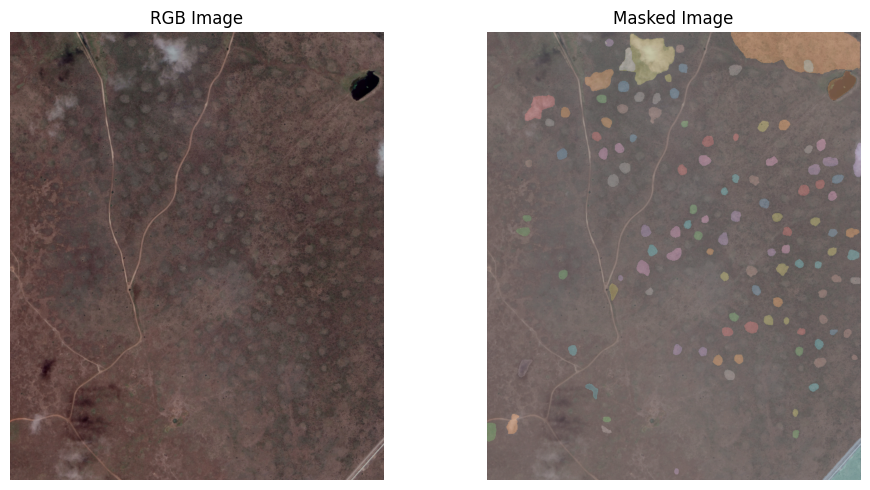

In [ ]:
display_masks2(image_resized, masks)

In [ ]:
# Salvataggio delle maschere (opzionale)
import os
output_dir = "/content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya_prova/segmented"
os.makedirs(output_dir, exist_ok=True)
for i, mask in enumerate(masks):
    mask_image = mask["segmentation"].astype("uint8") * 255
    cv2.imwrite(f"{output_dir}/mask_{i}.png", mask_image)

#SAM application to all images

In questa sezione il codice precedentemente implementato verrà modificato al fine di essere applicato ad un insieme di immagini.

In [ ]:
# Installazione delle librerie richieste
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-vylmpuco
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-vylmpuco
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=be318f9897e89a3cff82c840329ee70b522e10d5f923e54a30d3be7219fc7d20
  Stored in directory: /tmp/pip-ephem-wheel-cache-5a68bcey/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Scarica il modello pre-addestrato (vit_h)
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h_4b8939.pth

# Scarica il modello pre-addestrato (vit_b)
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b_01ec64.pth

--2025-02-03 15:34:19--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.81, 18.164.78.72, 18.164.78.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  93.4MB/s    in 22s     

2025-02-03 15:34:41 (113 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
# Percorso del modello
model_path = "/content/sam_vit_h_4b8939.pth"  # Assicurati che il file sia scaricato

# Caricare il modello e assegnarlo alla CPU
sam = sam_model_registry["vit_h"](checkpoint=model_path)
sam = sam.to("cpu") # Cambia in "cpu" se usi CPU, "cuda" per GPU

# Creare il generatore di maschere
mask_generator = SamAutomaticMaskGenerator(sam)
#mask_generator = SamAutomaticMaskGenerator( model=sam, points_per_side=8, pred_iou_thresh=0.7, stability_score_thresh=0.8)
      # Riduci il numero di punti (valore predefinito è 32)
      # Imposta una soglia inferiore per la qualità delle maschere
      # Riduci la soglia di stabilità

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
def process_image(image_path, output_drive_path, scale_percent=20):
    """
    Processa un'immagine: la ridimensiona, genera le maschere, le salva singolarmente e crea
    un'immagine con tutte le maschere sovrapposte.

    Parametri:
    - image_path: percorso completo dell'immagine originale
    - output_drive_path: cartella in cui salvare i risultati su Google Drive
    - scale_percent: percentuale di ridimensionamento dell'immagine
    """

    # Leggere l'immagine
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Estrarre il nome del file senza estensione
    image_name = os.path.basename(image_path).split('.')[0]  # Es. "201506_cropped"

    # Ridimensionare l'immagine
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    image_resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

    # Generare le maschere
    masks = mask_generator.generate(image_resized)
    masks.pop(0)

    # Creare la cartella per le maschere
    mask_folder = os.path.join(output_drive_path, f"{image_name}_masks")
    os.makedirs(mask_folder, exist_ok=True)

    # Salvare le maschere
    for i, mask in enumerate(masks):
        mask_image = mask["segmentation"].astype(np.uint8) * 255  # Convertire in immagine binaria
        mask_filename = os.path.join(mask_folder, f"{image_name}_mask_{i}.png")
        cv2.imwrite(mask_filename, mask_image)

    print(f"Salvate {len(masks)} maschere in {mask_folder}")

    # Creare l'immagine con maschere sovrapposte
    display_and_save_masks(image_resized, masks, output_drive_path, image_name)



In [ ]:
def display_and_save_masks(image, masks, output_drive_path, image_name):
    """
    Sovrappone tutte le maschere all'immagine originale e la salva.
    """

    # Creare una mappa di colori distinti per le maschere
    colors = list(mcolors.TABLEAU_COLORS.values())
    combined_mask = np.zeros_like(image, dtype=np.float32)

    # Sovrapporre le maschere con colori unici
    for i, mask in enumerate(masks):
        color = np.array(mcolors.to_rgb(colors[i % len(colors)]))
        segmentation = mask["segmentation"].astype(np.float32)
        for c in range(3):
            combined_mask[:, :, c] += segmentation * color[c]

    # Normalizzare la maschera combinata
    combined_mask = np.clip(combined_mask, 0, 1)

    # Creare la figura
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Immagine originale
    axes[0].imshow(image)
    axes[0].set_title("RGB Image")
    axes[0].axis("off")

    # Immagine con maschere sovrapposte
    axes[1].imshow(image, alpha=0.7)
    axes[1].imshow(combined_mask, alpha=0.2)
    axes[1].set_title("Masked Image")
    axes[1].axis("off")

    plt.tight_layout()

    # Salvare l'immagine con le maschere sovrapposte
    masked_image_path = os.path.join(output_drive_path, f"{image_name}_masked.png")
    plt.savefig(masked_image_path, format='png', dpi=300)
    plt.close()

    print(f"Immagine con maschere salvata in {masked_image_path}")


In [ ]:
# Specificare il percorso della cartella con le immagini su Google Drive
input_folder = "/content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/cropped"

# Specificare il percorso della cartella in cui salvare i risultati
output_folder = "/content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/masks"

# Creare la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Ottenere la lista delle immagini nella cartella
image_files = [f for f in os.listdir(input_folder) if f.endswith((".png"))]

# Elaborare tutte le immagini
for image_file in image_files:
    image_path = os.path.join(input_folder, image_file)
    process_image(image_path, output_folder)


Salvate 25 maschere in /content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/masks/201409_cropped_masks
Immagine con maschere salvata in /content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/masks/201409_cropped_masked.png
Salvate 27 maschere in /content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/masks/201411_cropped_masks
Immagine con maschere salvata in /content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/masks/201411_cropped_masked.png
Salvate 22 maschere in /content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/masks/201412_cropped_masks
Immagine con maschere salvata in /content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/masks/201412_cropped_masked.png
Salvate 15 maschere in /content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/masks/201501_cropped_masks
Immagine con maschere salvata in /content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/masks/201501_cropped_masked.png
Salvate 16 maschere in /content/drive/MyDrive/Colab Notebooks/Mat4Pat/GEP/Kenya/mask

#SAM with points

Le coordinate (x, y) sono espresse in pixel rispetto all'immagine

In [4]:
from segment_anything import sam_model_registry, SamPredictor

# Carica il modello SAM con un checkpoint pre-addestrato
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")

# Crea un oggetto per fare previsioni
predictor = SamPredictor(sam)

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [5]:
import cv2
import numpy as np

In [6]:
# Carica l'immagine
image = cv2.imread("/content/201812_cropped.png")

# Imposta l'immagine per il modello
predictor.set_image(image)

In [25]:
input_points = np.array([[2000, 435]])
input_labels = np.array([1])  # 1 significa "inclusione" dell'area

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True  # Se impostato, restituisce più maschere di segmentazione
)

In [28]:
masks.shape

(3, 4100, 3650)

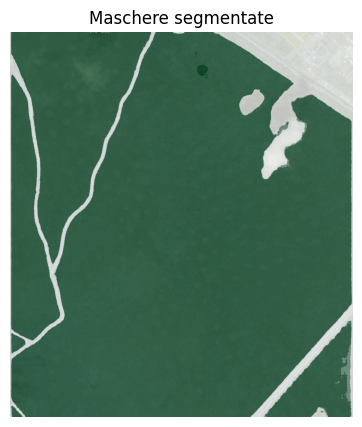

In [27]:
import matplotlib.pyplot as plt

# Visualizza l'immagine originale
plt.figure(figsize=(10, 5))
plt.imshow(image)  # L'immagine deve essere in formato RGB
plt.axis("off")

# Disegna le maschere sopra l'immagine
for mask in masks:
    plt.imshow(mask, alpha=0.4, cmap="Greens")  # Overlay della maschera
plt.title("Maschere segmentate")
plt.show()


In [ ]:
import cv2
import numpy as np

# Load image and mask
image = cv2.imread("image.jpg")  # Replace with your image path
mask = cv2.imread("mask.png", cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

# Find contours of the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Get the bounding square envelope
    x, y, w, h = cv2.boundingRect(contours[0])

    # Crop the square envelope from the original image
    cropped_square = image[y:y+h, x:x+w]

    # Create a blank mask for applying the irregular crop
    mask_inv = np.zeros_like(cropped_square, dtype=np.uint8)
    # Draw the filled contour on the cropped mask
    cv2.drawContours(mask_inv, contours, -1, (255, 255, 255), thickness=cv2.FILLED, offset=(-x, -y))

    # Convert to a binary mask
    mask_inv = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2GRAY)

    # Apply the irregular mask to crop the desired region
    cropped_image = cv2.bitwise_and(cropped_square, cropped_square, mask=mask_inv)

    # Save or show results
    cv2.imwrite("cropped_square.jpg", cropped_square)
    cv2.imwrite("cropped_irregular.jpg", cropped_image)

    cv2.imshow("Cropped Square", cropped_square)
    cv2.imshow("Cropped Irregular", cropped_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()